In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly
import matplotlib.pyplot as plt

import test
import mylayers
import util

# Used to save temporary variables
import pickle

# import asyncio

In [2]:
import os
filename = os.path.basename(globals()['__vsc_ipynb_file__']).split('.')[0]
filename

'CNN_edge_sobel'

## Read data

In [3]:
df_train = pd.read_csv("./data/fashion-mnist_train.csv")
df_valid = pd.read_csv("./data/fashion-mnist_test.csv")


### Shuffle the data set

In [4]:
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


### Seperate feature column and target columns

In [5]:
X_train = np.array(df_train.drop('label', axis=1), dtype="f")
Y_train = df_train.loc[:, 'label']
X_valid = np.array(df_valid.drop('label', axis=1), dtype="f")
Y_valid = df_valid.loc[:, 'label']


### Reshape graph

In [6]:
X_train.shape

(60000, 784)

In [7]:
X_train = X_train.reshape(X_train.shape[0],28,28)
X_valid = X_valid.reshape(X_valid.shape[0],28,28)


### One hot encoding Y

In [8]:
encoder = util.onehot_encoder(Y_train)
Y_train = encoder.encoding(Y_train)
Y_valid = encoder.encoding(Y_valid)


### new

In [9]:
m_train = X_train.shape[0]
m_valid = X_valid.shape[0]

<module 'matplotlib.pyplot' from 'c:\\Users\\bobmst\\.conda\\envs\\ds310\\lib\\site-packages\\matplotlib\\pyplot.py'>

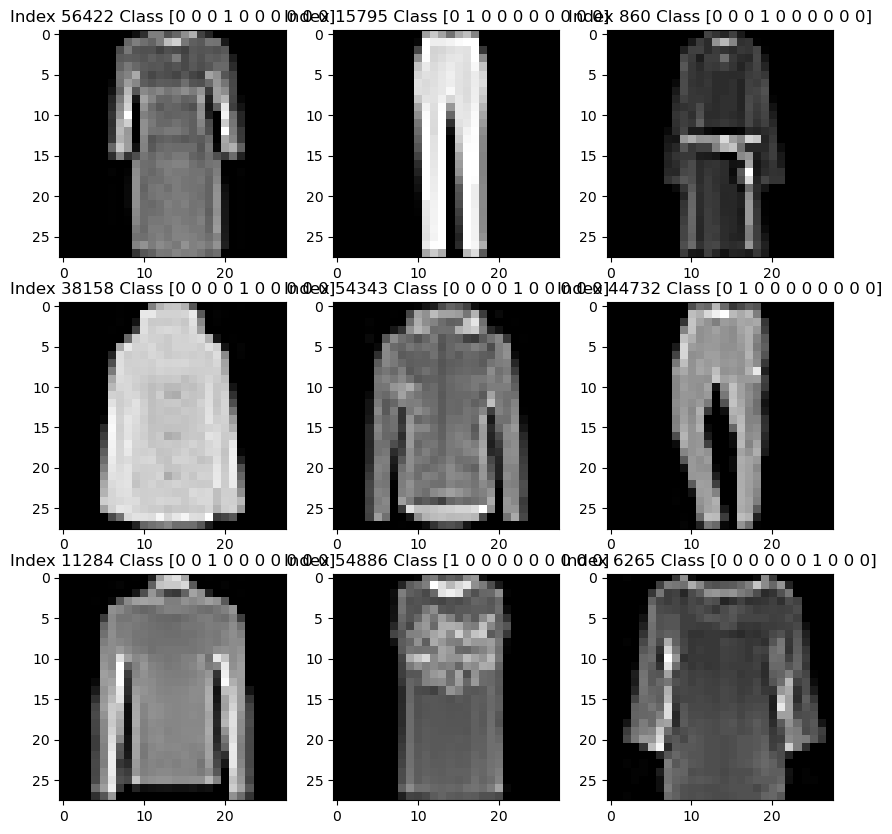

In [10]:
np.random.seed(42)
indices = list(np.random.randint(m_train,size=9))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[indices[i]], cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], Y_train[indices[i]]))

plt

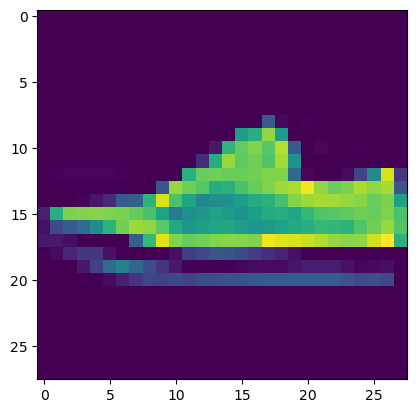

In [11]:
plt.imshow(X_train[0])

In [12]:
# Testing
# X_train = X_train[:500]
# Y_train = Y_train[:500]
# X_valid = X_valid[:5000]
# Y_valid = Y_valid[:5000]

## Build layers

In [13]:
layers = []
# ---Input Layer---
layers.append(mylayers.InputLayer(X_train))
# ---Convolutionary Layer 1---
I_x_sobel = np.array(
    [
        [-1,0,1],
        [-2,0,2],
        [-1,0,1],

    ]
)
conv_layer_1 = mylayers.ConvolutionLayer(1,3)
conv_layer_1.setKernels(I_x_sobel)
layers.append(conv_layer_1)
layers.append(mylayers.ReLuLayer())

# layers.append(mylayers.MaxPoolingLayer(2))
# ---Convolutionary Layer 2---
I_y_sobel = np.array(
    [
        [-1,-2,-1],
        [0,0,0],
        [1,1,1],

    ]
)
conv_layer_2 = mylayers.ConvolutionLayer(1,3)
conv_layer_2.setKernels(I_y_sobel)
layers.append(conv_layer_2)
layers.append(mylayers.ReLuLayer())

layers.append(mylayers.MaxPoolingLayer(2))
layers.append(mylayers.FlattenLayer())


# ---Hidden Layer 1---
# initialize FCL with xaiver
fc_layer = mylayers.FullyConnectedLayer(144, 120)
weights, biases = util.xaiver_init(144, 120)
fc_layer.setWeights(weights)
fc_layer.setBiases(biases)
layers.append(fc_layer)
layers.append(mylayers.TanhLayer())
# ---Hidden Layer 2---
# initialize FCL with xaiver
fc_layer = mylayers.FullyConnectedLayer(120, 84)
weights, biases = util.xaiver_init(120, 84)
fc_layer.setWeights(weights)
fc_layer.setBiases(biases)
layers.append(fc_layer)
layers.append(mylayers.TanhLayer())
# ---Hidden Layer 3---
# initialize FCL with xaiver
fc_layer = mylayers.FullyConnectedLayer(84, 10)
weights, biases = util.xaiver_init(84, 10)
fc_layer.setWeights(weights)
fc_layer.setBiases(biases)
layers.append(fc_layer)
layers.append(mylayers.SoftmaxLayer())
# ---Objective---
layers.append(mylayers.CrossEntropy())


In [14]:
layers

### layers test

In [15]:
hyperparams = {"epoch": 10, "eta": 2.5e-4, "batch_size": 32, "rho1": 0.9, "rho2": 0.999}

In [16]:
epoch = hyperparams['epoch']
eta = hyperparams['eta']
batch_size = hyperparams['batch_size']
rho1 = hyperparams['rho1']
rho2 = hyperparams['rho2']
ls_scores_train,Y_hat,ls_accuracy_train,ls_scores_valid,ls_accuracy_valid = test.adam_learn_with_validation(X_train,Y_train,X_valid,Y_valid,layers,mylayers.CrossEntropy,epoch=epoch,eta=eta,print_eval=False,print_layer=False,batch_size=batch_size)


100%|██████████| 10/10 [2:37:53<00:00, 947.32s/it] 


In [17]:
train_results = {
    'hyperparams' : hyperparams,
    'ls_scores_train':ls_scores_train,
    'Y_hat':Y_hat,
    'ls_accuracy_train':ls_accuracy_train
    ,'ls_scores_valid':ls_scores_valid,
    'ls_accuracy_valid':ls_accuracy_valid
}

In [18]:
# save model
with open(f"models/model_{filename}.pkl", "wb") as f:
    pickle.dump(layers, f)

# save result to pickle
with open(f"models/{filename}.pkl", "wb") as f:
    pickle.dump(train_results, f)

In [19]:
# read result from pickle
with open(f'models/{filename}.pkl', 'rb') as f:
    train_results = pickle.load(f)
    
hyperparams = train_results['hyperparams']
ls_scores_train = train_results['ls_scores_train']
Y_hat = train_results['Y_hat']
ls_accuracy_train = train_results['ls_accuracy_train']
ls_scores_valid = train_results['ls_scores_valid']
ls_accuracy_valid = train_results['ls_accuracy_valid']

In [20]:
# graph of scores
hidden_layers = "conv -> max pooling -> tanh -> tanh -> softmax"
fig = util.draw_scores_with_validation(
    ls_scores_train, ls_scores_valid, hidden_layers, hyperparams
)
fig.show()


In [21]:
# graph of accuracys
fig = util.draw_accuracys_with_validation(
    ls_accuracy_train, ls_accuracy_valid, hidden_layers, hyperparams
)
fig.show()


### validate accuracy

In [22]:
labeled_Y_hat = encoder.decoding(Y_hat)
labeled_Y_hat


[7,
 8,
 8,
 5,
 9,
 1,
 4,
 3,
 6,
 2,
 9,
 0,
 7,
 1,
 6,
 0,
 6,
 2,
 9,
 1,
 2,
 8,
 8,
 0,
 4,
 9,
 1,
 6,
 6,
 5,
 1,
 6,
 4,
 7,
 3,
 3,
 9,
 9,
 4,
 8,
 2,
 2,
 4,
 2,
 1,
 5,
 4,
 2,
 6,
 9,
 1,
 0,
 3,
 5,
 8,
 9,
 5,
 1,
 1,
 2,
 3,
 8,
 3,
 1,
 4,
 8,
 0,
 9,
 4,
 0,
 5,
 6,
 5,
 3,
 6,
 2,
 0,
 5,
 4,
 1,
 1,
 8,
 9,
 7,
 5,
 2,
 9,
 2,
 6,
 3,
 2,
 4,
 4,
 6,
 9,
 7,
 5,
 8,
 7,
 0,
 4,
 0,
 2,
 7,
 3,
 2,
 1,
 2,
 4,
 4,
 5,
 9,
 6,
 7,
 3,
 1,
 8,
 9,
 1,
 5,
 1,
 1,
 6,
 2,
 7,
 8,
 9,
 5,
 9,
 4,
 5,
 3,
 7,
 1,
 6,
 9,
 2,
 3,
 7,
 3,
 6,
 2,
 9,
 7,
 1,
 1,
 5,
 7,
 8,
 1,
 8,
 5,
 1,
 2,
 2,
 7,
 9,
 0,
 1,
 3,
 9,
 0,
 6,
 1,
 4,
 6,
 5,
 4,
 8,
 3,
 0,
 9,
 3,
 6,
 7,
 5,
 4,
 6,
 8,
 1,
 9,
 9,
 6,
 2,
 9,
 2,
 1,
 4,
 3,
 5,
 5,
 4,
 9,
 1,
 4,
 3,
 1,
 2,
 5,
 2,
 8,
 5,
 1,
 1,
 3,
 9,
 0,
 1,
 0,
 6,
 3,
 8,
 0,
 5,
 4,
 1,
 0,
 9,
 2,
 4,
 7,
 7,
 5,
 9,
 7,
 6,
 6,
 5,
 8,
 3,
 8,
 9,
 2,
 6,
 4,
 3,
 0,
 5,
 9,
 1,
 4,
 2,
 6,
 2,
 7,
 8,
 9,
 5,
 8,
 3,


In [23]:
labeled_Y = encoder.decoding(Y_train)
labeled_Y


[7,
 8,
 8,
 5,
 9,
 1,
 2,
 6,
 6,
 2,
 5,
 0,
 7,
 1,
 6,
 0,
 6,
 2,
 9,
 1,
 2,
 4,
 8,
 0,
 4,
 9,
 1,
 0,
 0,
 5,
 1,
 6,
 2,
 7,
 3,
 4,
 9,
 9,
 4,
 8,
 2,
 6,
 0,
 2,
 1,
 5,
 4,
 4,
 6,
 9,
 1,
 3,
 2,
 5,
 8,
 9,
 5,
 1,
 1,
 2,
 3,
 8,
 3,
 1,
 2,
 8,
 0,
 9,
 4,
 0,
 5,
 6,
 5,
 2,
 6,
 2,
 0,
 5,
 2,
 1,
 1,
 6,
 9,
 7,
 5,
 2,
 9,
 2,
 6,
 3,
 2,
 4,
 4,
 2,
 9,
 7,
 5,
 8,
 7,
 0,
 8,
 0,
 2,
 7,
 3,
 2,
 1,
 2,
 4,
 2,
 5,
 9,
 4,
 7,
 3,
 1,
 8,
 9,
 1,
 5,
 1,
 3,
 2,
 2,
 7,
 8,
 9,
 5,
 9,
 4,
 5,
 3,
 7,
 1,
 6,
 9,
 2,
 3,
 7,
 4,
 6,
 2,
 9,
 7,
 1,
 1,
 5,
 7,
 8,
 1,
 8,
 5,
 1,
 2,
 2,
 7,
 9,
 0,
 1,
 4,
 9,
 0,
 6,
 1,
 2,
 6,
 5,
 4,
 8,
 3,
 0,
 9,
 3,
 6,
 7,
 5,
 4,
 0,
 8,
 1,
 9,
 9,
 6,
 6,
 9,
 2,
 1,
 6,
 3,
 5,
 5,
 4,
 9,
 1,
 4,
 3,
 1,
 2,
 5,
 2,
 8,
 5,
 1,
 1,
 3,
 9,
 0,
 1,
 0,
 6,
 3,
 8,
 0,
 5,
 8,
 1,
 0,
 9,
 2,
 2,
 7,
 5,
 5,
 9,
 7,
 6,
 6,
 5,
 8,
 3,
 6,
 9,
 2,
 6,
 2,
 3,
 0,
 7,
 9,
 1,
 4,
 2,
 6,
 2,
 7,
 8,
 9,
 7,
 8,
 3,


In [24]:
c = 0
for i in range(len(labeled_Y)):
    if labeled_Y[i] == labeled_Y_hat[i]:
        c += 1
print("Final Accuracy:", (c / len(labeled_Y)) * 100, "%")


Final Accuracy: 83.37 %
